In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import pymc
from pymc import utils
from pymc.database import base
import pygem_input as input

import glob

#plotting functions
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.mlab as mlab
from scipy.stats import gaussian_kde
import scipy.stats as stats
from scipy.stats import truncnorm
from scipy.stats import norm
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

variables = ['massbal', 'precfactor', 'tempchange', 'ddfsnow']  
vn_title_dict = {'massbal':'Mass Balance',                                                                      
                 'precfactor':'Precipitation Factor',                                                              
                 'tempchange':'Temperature Bias',                                                               
                 'ddfsnow':'DDF Snow'}
vn_label_dict = {'massbal':'Mass balance\n[mwea]',                                                                      
                 'precfactor':'Precipitation factor\n[-]',                                                              
                 'tempchange':'Temperature bias\n[degC]',                                                               
                 'ddfsnow':'DDF Snow\n[mwe $degC^{-1} d^{-1}$]'}
metric_title_dict = {'Gelman-Rubin':'Gelman-Rubin Statistic',
                     'MC Error': 'Monte Carlo Error',
                     'Effective N': 'Effective Sample Size'}
metrics = ['Gelman-Rubin', 'MC Error', 'Effective N']

suffix = '_15000'
mcmc_output_netcdf_fp = '../MCMC_data/netcdf' + suffix + '/'
mcmc_output_figures_fp = '../MCMC_data/figures' + suffix + '/'
mcmc_output_tables_fp = '../MCMC_data/tables/'
mcmc_output_csv_fp = '../MCMC_data/csv' + suffix + '/'
mcmc_output_hist_fp = '../MCMC_data/hist' + suffix + '/'

In [9]:
def plot_histograms_15000(iters, burn, region=15, dfs=None):
    '''
    Plots histograms to assess mcmc chains for groups of glaciers.
    Puts them all in one image file.

    Plots histograms of effective_n, gelman-rubin and mc error for
    the given number of iterations and burn-in and the given variable.

    For this function to work, the appropriate csv file must have already
    been created.

    Parameters
    ----------
    iters : int
        Number of iterations associated with the Markov Chain
    burn : list of ints
        List of burn in values to plot for Gelman-Rubin stats
    region : int
        RGI region number  or 'all'
    dfs : list of pandas.DataFrame
        list of dataframes containing glacier information to be plotted. If
        none, looks for appropriate csv file

    Returns
    -------
    .png files
        Saves images to 3 png files.

    '''

    # hard code some variable names (dirty solution)
    variables = ['massbal', 'precfactor', 'tempchange', 'ddfsnow']
    vn_title_dict = {'massbal':'Mass Balance',
                     'precfactor':'Precipitation Factor',
                     'tempchange':'Temperature Bias',
                     'ddfsnow':'DDF Snow'}
    metric_title_dict = {'Gelman-Rubin':'Gelman-Rubin Statistic',
                         'MC Error': 'Monte Carlo Error',
                         'Effective N': 'Effective Sample Size'}
    metrics = ['MC Error', 'Effective N']
    vn_label_dict = {'massbal':'[mwea]',
                     'precfactor':'[-]',
                     'tempchange':'[$^{o}$C]',
                     'ddfsnow':'[mwe $degC^{-1} d^{-1}$]'}

    # hard code font sizes
    ticks=10
    suptitle=14
    title=11
    titley = 1.05
    label=10
    plotline=1.25
    plotline2=1.25
    legend=10
    figsize=(6.5, 9)
    dpi=100
    hspace=0.6
    wspace=0.2
    colors = ['#387ea0', '#d20048', '#fcb200']
    alpha = 0.7

    # bins and ticks
    bdict = {}
    tdict = {}
    major = {}
    minor = {}

    bdict['MC Error massbal'] = np.arange(0, 0.012, 0.0006)
    bdict['MC Error tempchange'] = np.arange(0, 0.25, 0.0125)
    bdict['MC Error ddfsnow'] = np.arange(0, 4.5, 0.225)
    bdict['MC Error precfactor'] = np.arange(0, 8, 0.4)
    bdict['Effective N massbal'] = np.arange(0, 8000, 400)
    bdict['Effective N ddfsnow'] = np.arange(0, 3500, 175)
    bdict['Effective N tempchange'] = np.arange(0, 2000, 100)
    bdict['Effective N precfactor'] = np.arange(0, 2500, 125)
    tdict['MC Error'] = np.arange(0, 21, 4)
    tdict['Effective N'] = np.arange(0, 21, 4)
    major['MC Error massbal'] = MultipleLocator(0.005)
    major['MC Error tempchange'] = MultipleLocator(0.1)
    major['MC Error ddfsnow'] = MultipleLocator(1)
    major['MC Error precfactor'] = MultipleLocator(2)
    major['Effective N massbal'] = MultipleLocator(2000)
    major['Effective N ddfsnow'] = MultipleLocator(1000)
    major['Effective N tempchange'] = MultipleLocator(500)
    major['Effective N precfactor'] = MultipleLocator(1000)
    minor['MC Error massbal'] = MultipleLocator(0.001)
    minor['MC Error tempchange'] = MultipleLocator(0.02)
    minor['MC Error ddfsnow'] = MultipleLocator(0.2)
    minor['MC Error precfactor'] = MultipleLocator(0.4)
    minor['Effective N massbal'] = MultipleLocator(400)
    minor['Effective N ddfsnow'] = MultipleLocator(200)
    minor['Effective N tempchange'] = MultipleLocator(100)
    minor['Effective N precfactor'] = MultipleLocator(200)

    # read csv files
    vn_df_dict = {}
    if region in [13, 14, 15]:
        for vn in variables:
            vn_df_dict[vn] = pd.read_csv(mcmc_output_csv_fp + 'region' +
                                         str(region) + '_' + str(iters) +
                                         'iterations_' + str(burn) + 'burn_' +
                                         str(vn) + suffix2 + '.csv')
    elif region == 'all':
        for vn in variables:        
            regions = [13, 14, 15]
            dfs = []
            for reg in regions:
                dfs.append(pd.read_csv(mcmc_output_csv_fp + 'region' +
                                       str(reg) + '_' + str(iters) +
                                       'iterations_' + str(burn) + 'burn_' +
                                       str(vn) + '2.csv'))
            vn_df_dict[vn] = pd.concat(dfs)

    # get variables and burn length for dimension
    v_len = len(variables)
    m_len = len(metrics)

    # create figure
    fig = plt.figure(figsize=figsize, dpi=dpi)
    plt.subplots_adjust(wspace=wspace, hspace=hspace)

    #create subplot for each metric
    for m_count, metric in enumerate(metrics):

        # create subplot for each variable
        for v_count, vn in enumerate(variables):
            
            df = vn_df_dict[vn]
            
            # plot histogram
            ax = plt.subplot(v_len, m_len, m_len*v_count+m_count+1)
            ax2 = ax.twinx()

            # compute histogram and change to percentage of glaciers
            #print(suffix, metric, vn)
            if metric == 'MC Error' and (vn == 'ddfsnow' or vn == 'precfactor'):
                a = df[metric] * 100.0 / df['Mean']
            else:
                a = df[metric]
                
                
            hist, bins = np.histogram(a=a, bins=bdict[metric + ' ' + vn])
            hist = hist * 100.0 / hist.sum() 
            #print(sum(hist))

            # plot histogram
            ax.bar(x=bins[1:], height=hist, width=(bins[1]-bins[0]), align='center',
                   alpha=alpha, edgecolor='black', color=colors[m_count])

            # create uniform bins based on metric
            ax.set_yticks(tdict[metric])

            # find cumulative percentage and plot it
            cum_hist = [hist[0:i].sum() for i in range(len(hist))]
            #print(len(bins))
            #print(len(cum_hist))
            # find 5 % point or 95 % point
            if metric=='Effective N':
                percent = 5
                q = 0.05
            else:
                percent = 95
                q = 0.95
            index = 0
            quantile = a.quantile(q)
            for point in cum_hist:
                if point < percent:
                    index += 1
            #print(index)
            ax2.plot(bins[:-1], cum_hist, color='black',
                     linewidth=plotline, label='Cumulative %')
            ax2.set_yticks(np.arange(0, 110, 20))

            #ax2.axvline(bins[index], color='black',
                     #linewidth=plotline2, linestyle='--')
            ax2.axvline(quantile, color='black',
                     linewidth=plotline2, linestyle='--')

            # set tick sizes
            ax.tick_params(labelsize=ticks)
            ax2.tick_params(labelsize=ticks)

            ax2.set_ylim(0, 100)
            #ax.set_xlim(bins[0], bins[-1])

            # niceties
            if v_count == 0:
                plt.title(metric_title_dict[metric], fontsize=label, y=titley)

            # axis labels
            if m_count == 0:
                ax.set_ylabel(vn_title_dict[vn] + '\n\n% of Glaciers', fontsize=label, labelpad=3)
            if m_count == 1:
                ax2.set_ylabel('Cumulative %', fontsize=label, rotation = 270, labelpad=15)
            if metric == 'MC Error' and (vn == 'massbal' or vn == 'tempchange'):
                ax.set_xlabel(vn_label_dict[vn], fontsize=label)
            elif metric=='MC Error':
                ax.set_xlabel('[% of mean]', fontsize=label)
            #elif metric == 'Effective N':
                #ax.set_xlabel('Effective Sample Size', fontsize=label)
            #else:
                #ax.set_xlabel(metric, fontsize=label)
                
            ax.xaxis.set_major_locator(major[metric + ' ' + vn])
            ax.xaxis.set_minor_locator(minor[metric + ' ' + vn])
                
            # legend
            #if v_count==3 and m_count==2:
                #ax2.legend(loc='best', fontsize=legend)
                
            if m_count == 0:
                ax2.yaxis.set_major_locator(plt.NullLocator())
            if m_count == 1:
                ax.yaxis.set_major_locator(plt.NullLocator())

    # Save figure
    #plt.savefig(mcmc_output_hist_fp + 'histrogram_mixed.png',
                #bbox_inches='tight')

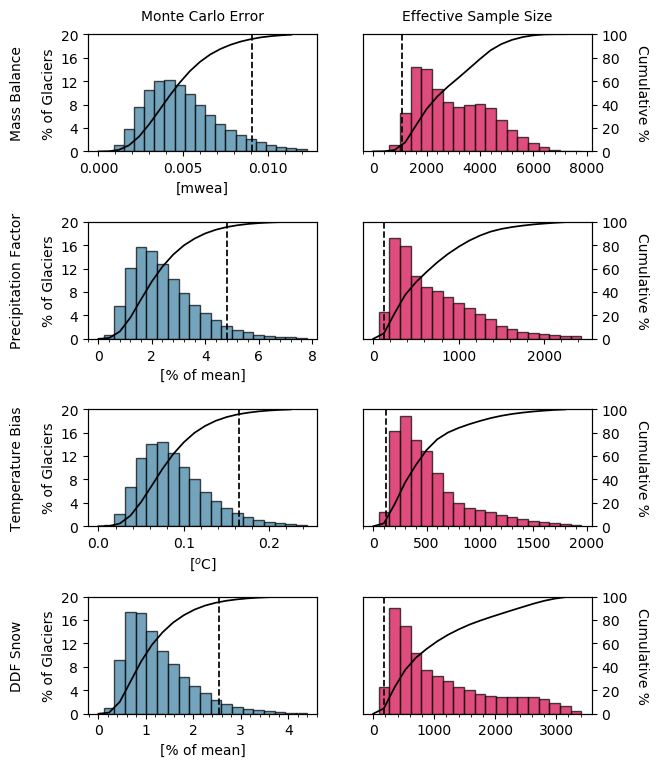

In [10]:
plot_histograms_15000(15000, 0, 'all')

In [10]:
region = 13
iters = 15000
burn = 0
vn = 'massbal'
df = pd.read_csv(mcmc_output_csv_fp + 'region' +
                                       str(region) + '_' + str(iters) +
                                       'iterations_' + str(burn) + 'burn_' +
                                       str(vn) + '2.csv')
df2 = pd.read_csv(mcmc_output_csv_fp + 'region' +
                    str(14) + '_' + str(iters) +
                   'iterations_' + str(burn) + 'burn_' +
                   str(vn) + '2.csv')
df3 = pd.read_csv(mcmc_output_csv_fp + 'region' +
                    str(15) + '_' + str(iters) +
                   'iterations_' + str(burn) + 'burn_' +
                   str(vn) + '2.csv')
dfs = [df, df2, df3]

In [11]:
final = pd.concat(dfs)

In [12]:
final

,Glacier,Effective N,MC Error,Mean
0,13.28239,2122,0.005690,0.422562
1,13.34725,3547,0.005384,0.160366
2,13.45530,1199,0.007778,0.155593
3,13.52577,1866,0.004260,0.123927
4,13.13478,2924,0.003375,0.362897
5,13.48728,2567,0.003266,0.099529
6,13.01671,3615,0.003572,0.434819
7,13.42171,1050,0.002909,0.166424
8,13.27416,3506,0.004635,0.617048
9,13.02008,4450,0.003788,0.531022


In [18]:
len(df) + len(df3)

67539

In [14]:
len(df2)

27985

In [15]:
len(df3)

13115

In [18]:
def plot_histograms_trunc(iters, burn, region=15, dfs=None):
    '''
    Plots histograms to assess mcmc chains for groups of glaciers.
    Puts them all in one image file.

    Plots histograms of effective_n, gelman-rubin and mc error for
    the given number of iterations and burn-in and the given variable.

    For this function to work, the appropriate csv file must have already
    been created.

    Parameters
    ----------
    iters : int
        Number of iterations associated with the Markov Chain
    burn : list of ints
        List of burn in values to plot for Gelman-Rubin stats
    region : int
        RGI region number  or 'all'
    dfs : list of pandas.DataFrame
        list of dataframes containing glacier information to be plotted. If
        none, looks for appropriate csv file

    Returns
    -------
    .png files
        Saves images to 3 png files.

    '''

    # hard code some variable names (dirty solution)
    variables = ['massbal', 'precfactor', 'tempchange', 'ddfsnow']
    vn_title_dict = {'massbal':'Mass Balance',
                     'precfactor':'Precipitation Factor',
                     'tempchange':'Temperature Bias',
                     'ddfsnow':'DDF Snow'}
    metric_title_dict = {'Gelman-Rubin':'Gelman-Rubin',
                         'MC Error': 'Monte Carlo Error',
                         'Effective N': 'Effective Sample Size'}
    metrics = ['Gelman-Rubin', 'MC Error', 'Effective N']
    vn_label_dict = {'massbal':'[mwea]',
                     'precfactor':'[-]',
                     'tempchange':'[$^{o}$C]',
                     'ddfsnow':'[mwe $degC^{-1} d^{-1}$]'}

    # hard code font sizes
    ticks=10
    suptitle=14
    title=11
    titley = 1.05
    label=10
    plotline=1.25
    plotline2=1.25
    legend=10
    figsize=(6.5, 9)
    dpi=100
    hspace=0.5
    wspace=0.3
    colors = ['#387ea0', '#d20048', '#fcb200']
    alpha = 0.7

    # bins and ticks
    bdict = {}
    tdict = {}
    major = {}
    minor = {}

    bdict['MC Error massbal'] = np.arange(0, 0.012, 0.0006)
    bdict['MC Error tempchange'] = np.arange(0, 0.25, 0.0125)
    bdict['MC Error ddfsnow'] = np.arange(0, 4.5, 0.225)
    bdict['MC Error precfactor'] = np.arange(0, 8, 0.4)
    bdict['Effective N massbal'] = np.arange(0, 8000, 400)
    bdict['Effective N ddfsnow'] = np.arange(0, 3500, 175)
    bdict['Effective N tempchange'] = np.arange(0, 2000, 100)
    bdict['Effective N precfactor'] = np.arange(0, 2400, 120)
    bdict['Gelman-Rubin massbal'] = np.arange(1, 1.003, 0.00015)
    bdict['Gelman-Rubin precfactor'] = np.arange(1.0, 1.019, 0.00095)
    bdict['Gelman-Rubin tempchange'] = np.arange(1.00, 1.02, 0.001)
    bdict['Gelman-Rubin ddfsnow'] = np.arange(1.0, 1.01, 0.0005)
    tdict['MC Error'] = np.arange(0, 31, 5)
    tdict['Effective N'] = np.arange(0, 31, 5)
    tdict['Gelman-Rubin'] = np.arange(0, 31, 5)
    major['MC Error massbal'] = MultipleLocator(0.01)
    major['MC Error tempchange'] = MultipleLocator(0.1)
    major['MC Error ddfsnow'] = MultipleLocator(1)
    major['MC Error precfactor'] = MultipleLocator(2)
    major['Gelman-Rubin massbal'] = MultipleLocator(0.002)
    major['Gelman-Rubin tempchange'] = MultipleLocator(0.02)
    major['Gelman-Rubin ddfsnow'] = MultipleLocator(0.005)
    major['Gelman-Rubin precfactor'] = MultipleLocator(0.01)
    major['Effective N massbal'] = MultipleLocator(4000)
    major['Effective N ddfsnow'] = MultipleLocator(2000)
    major['Effective N tempchange'] = MultipleLocator(1000)
    major['Effective N precfactor'] = MultipleLocator(2000)
    minor['Gelman-Rubin massbal'] = MultipleLocator(0.0004)
    minor['Gelman-Rubin tempchange'] = MultipleLocator(0.004)
    minor['Gelman-Rubin ddfsnow'] = MultipleLocator(0.001)
    minor['Gelman-Rubin precfactor'] = MultipleLocator(0.002)
    minor['MC Error massbal'] = MultipleLocator(0.002)
    minor['MC Error tempchange'] = MultipleLocator(0.02)
    minor['MC Error ddfsnow'] = MultipleLocator(0.2)
    minor['MC Error precfactor'] = MultipleLocator(1)
    minor['Effective N massbal'] = MultipleLocator(800)
    minor['Effective N ddfsnow'] = MultipleLocator(400)
    minor['Effective N tempchange'] = MultipleLocator(200)
    minor['Effective N precfactor'] = MultipleLocator(400)

    # read csv files
    vn_df_dict = {}
    if region in [13, 14, 15]:
        for vn in variables:
            vn_df_dict[vn] = pd.read_csv(mcmc_output_csv_fp + 'region' +
                                         str(region) + '_' + str(iters) +
                                         'iterations_' + str(burn) + 'burn_' +
                                         str(vn) + suffix2 + '.csv')
            
    elif region == 'all':
        for vn in variables:
            regions = [13, 14, 15]
            vn_df_dict[vn] = pd.read_csv(mcmc_output_csv_fp + 'region' +
                                       str(region) + '_' + str(iters) +
                                       'iterations_' + str(burn) + 'burn_' +
                                       str(vn) + '.csv')
            vn_df_dict[vn + '_unnormalized'] = pd.read_csv(mcmc_output_csv_fp + 'region' +
                                       str(region) + '_' + str(iters) +
                                       'iterations_' + str(burn) + 'burn_' +
                                       str(vn) + 'without_normalization.csv')

    # get variables and burn length for dimension
    v_len = len(variables)
    m_len = len(metrics)

    # create figure
    fig = plt.figure(figsize=figsize, dpi=dpi)
    plt.subplots_adjust(wspace=wspace, hspace=hspace)

    #create subplot for each metric
    for m_count, metric in enumerate(metrics):

        # create subplot for each variable
        for v_count, vn in enumerate(variables):
            
            df = vn_df_dict[vn]
            
            # plot histogram
            ax = plt.subplot(v_len, m_len, m_len*v_count+m_count+1)
            ax2 = ax.twinx()

            # compute histogram and change to percentage of glaciers
            if metric == 'MC Error' and (vn == 'massbal' or vn == 'tempchange'):
                df = vn_df_dict[vn + '_unnormalized']
            else:
                df = vn_df_dict[vn]
                
            a = df[metric]
                
            hist, bins = np.histogram(a=a, bins=bdict[metric + ' ' + vn])
            hist = hist * 100.0 / hist.sum() 

            # plot histogram
            ax.bar(x=bins[1:], height=hist, width=(bins[1]-bins[0]), align='center',
                   alpha=alpha, edgecolor='black', color=colors[m_count])

            # create uniform bins based on metric
            ax.set_yticks(tdict[metric])

            # find cumulative percentage and plot it
            cum_hist = [hist[0:i].sum() for i in range(len(hist))]

            # find 5 % point or 95 % point
            if metric=='Effective N':
                percent = 5
                q = 0.05
            else:
                percent = 95
                q = 0.95
            index = 0
            quantile = a.quantile(q)
            for point in cum_hist:
                if point < percent:
                    index += 1
            #print(index)
            ax2.plot(bins[:-1], cum_hist, color='black',
                     linewidth=plotline, label='Cumulative %')
            ax2.set_yticks(np.arange(0, 110, 20))

            #ax2.axvline(bins[index], color='black',
                     #linewidth=plotline2, linestyle='--')
            ax2.axvline(quantile, color='black',
                     linewidth=plotline2, linestyle='--')
            # set tick sizes
            ax.tick_params(labelsize=ticks)
            ax2.tick_params(labelsize=ticks)

            ax2.set_ylim(0, 100)

            # niceties
            if v_count == 0:
                plt.title(metric_title_dict[metric], fontsize=label, y=titley)

            # axis labels
            if m_count == 0:
                ax.set_ylabel(vn_title_dict[vn] + '\n\n% of Glaciers', fontsize=label, labelpad=3)
            if m_count == 2:
                ax2.set_ylabel('Cumulative %', fontsize=label, rotation = 270, labelpad=10)
            if metric == 'MC Error' and (vn == 'massbal' or vn == 'tempchange'):
                ax.set_xlabel(vn_label_dict[vn], fontsize=label)
            elif metric=='MC Error':
                ax.set_xlabel('[% of mean]', fontsize=label)
            #elif metric == 'Effective N':
                #ax.set_xlabel('Effective Sample Size', fontsize=label)
            #else:
                #ax.set_xlabel(metric, fontsize=label)
                
            ax.xaxis.set_major_locator(major[metric + ' ' + vn])
            ax.xaxis.set_minor_locator(minor[metric + ' ' + vn])
            
            if m_count == 0 or m_count == 1:
                ax2.yaxis.set_major_locator(plt.NullLocator())
            if m_count == 1 or m_count == 2:
                ax.yaxis.set_major_locator(plt.NullLocator())
                
            # legend
            #if v_count==3 and m_count==2:
                #ax2.legend(loc='best', fontsize=legend)

    # Save figure
    #plt.savefig(mcmc_output_hist_fp + 'histrogram_mixed_sample.png',
                #bbox_inches='tight')

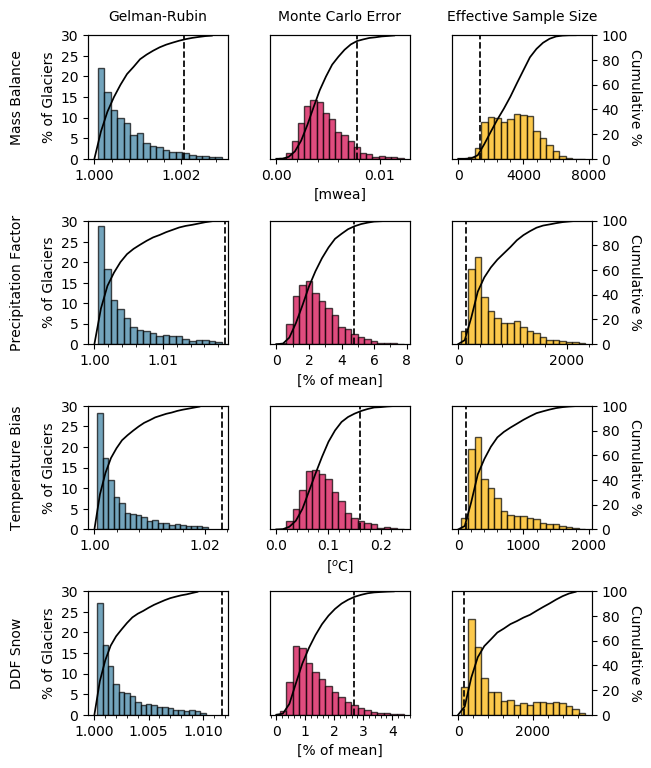

In [19]:
plot_histograms_trunc(15000, 0, 'all')

In [6]:
def find_thresholds(iters, burn, region=15, dfs=None):
    '''


    '''
    variables = ['massbal', 'precfactor', 'tempchange', 'ddfsnow']

    if suffix == '_15000':
        metrics = ['MC Error', 'Effective N']
    else:
        metrics = ['Gelman-Rubin', 'MC Error', 'Effective N']

    # read csv files
    vn_df_dict = {}
    if region in [13, 14, 15]:
        for vn in variables:
            vn_df_dict[vn] = pd.read_csv(mcmc_output_csv_fp + 'region' +
                                         str(region) + '_' + str(iters) +
                                         'iterations_' + str(burn) + 'burn_' +
                                         str(vn) + suffix2 + '.csv')
    elif region == 'all':
        for vn in variables:        
            regions = [13, 14, 15]
            dfs = []
            for reg in regions:
                dfs.append(pd.read_csv(mcmc_output_csv_fp + 'region' +
                                       str(reg) + '_' + str(iters) +
                                       'iterations_' + str(burn) + 'burn_' +
                                       str(vn) + '2.csv'))
            vn_df_dict[vn] = pd.concat(dfs)


    #create subplot for each metric
    for m_count, metric in enumerate(metrics):

        # create subplot for each variable
        for v_count, vn in enumerate(variables):

            if metric == 'MC Error' and (vn == 'precfactor' or vn == 'ddfsnow'):
                df = vn_df_dict[vn][metric] * 100.0 / vn_df_dict[vn]['Mean']
            else:
                df = vn_df_dict[vn][metric]

            if metric == "Effective N":
                q = 0.05
            else:
                q = 0.95

            threshold = df.quantile(q=q)
            
            if metric == 'Effective N':
                a = 100
            elif metric == 'MC Error':
                 a = 5
            elif metric == 'Gelman-Rubin':
                a = 1.1
                
            error = stats.percentileofscore(df, a)
            quantile = df.quantile(q)
            

            print(vn, metric, threshold, error, quantile)

In [7]:
find_thresholds(15000, 0, 'all')

massbal MC Error 0.009046833106922347 100.0 0.009046833106922347
precfactor MC Error 4.800477899642766 95.85601239323397 4.800477899642766
tempchange MC Error 0.16402338933278507 100.0 0.16402338933278507
ddfsnow MC Error 2.532063808684218 99.93719644950595 2.532063808684218
massbal Effective N 1090.0 0.002093714668564968 1090.0
precfactor Effective N 129.0 2.435207670406967 129.0
tempchange Effective N 122.0 2.5430204320884275 122.0
ddfsnow Effective N 180.0 0.6876988779098978 180.0
